In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
from nltk import word_tokenize, sent_tokenize
from utils import Serialization

tqdm.pandas()

/u/jai/miniconda3/envs/venv37/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
ROOT_DIR = "/ais/hal9000/datasets/reddit/stance_analysis/"
files = list(os.walk(ROOT_DIR))
df = pd.read_json(files[1][0] + "/aa", lines=True)

In [4]:
df

,author,body,controversiality,created_utc,id,parent_id,score,subreddit,author_flair_text,author_flair_css_class,BF,BF_markers,BF_EX,BF_EX_markers,DA,DA_markers,DA_EX,DA_EX_markers
0,TheSituasian,It was supposed to be Ahri...........,1,1396310400,cggwbpx,t3_21v3gc,3,leagueoflegends,[mikekim] (NA),33 team,1,supposed,0,,0,,0,
1,soitgoes93,"Just a guess, but, Germany?",0,1396310400,cggwbpy,t1_cggtzi3,4,AskMen,♂,male,1,just,0,,0,,0,
2,Stinky-pickle,That would have been a goal if it wasn't for T...,0,1396310400,cggwbq2,t3_21vc3k,3,hockey,OTTAlt2NHL,OTTAlt2NHL,1,would,0,,0,,0,
3,UCSp1tF1r3,"I sent you a friend request, my steam name is ...",0,1396310400,cggwbq3,t1_cggcwfz,1,DotA2,,traxex,1,seem__like__can__really__hope__would,1,pretty__although,1,like__right__really__my,0,
4,valoirlecoup,"Yeah it sucked, but it was over three years ag...",0,1396310400,cggwbq4,t1_cggw9gh,10,Unexpected,None,None,0,,1,yeah,1,yeah,0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,ishyman,shitty LPT- do it while your iron is hot to ma...,0,1396369982,cghex12,t1_cggpu0f,1,AskReddit,None,None,1,sure,1,shitty,1,sure,0,
499996,Ripper62,you may as well be using a mana addict if you ...,0,1396369981,cghex13,t1_cggl5bv,1,hearthstone,,hogger,1,may__can__really__could,0,,1,now__so__really__well,0,
499997,ParisPC07,Everyone can't have equal rights in a capitali...,0,1396369982,cghex15,t1_cggke58,2,bestof,None,None,1,will,1,always,0,,1,always
499998,tedstery,Welp. No word on their twitter either.,0,1396369982,cghex17,t3_21xnxu,1,elderscrollsonline,Daggerfall Covenant,daggerfall,0,,0,,1,no,0,


In [5]:
ROOT_DIR = "/ais/hal9000/datasets/reddit/stance_analysis/"
files = list(os.walk(ROOT_DIR))
df = pd.read_json(files[1][0] + "/aa", lines=True)

stance_groups = pd.read_json("../stancemarkers/stancemarkers.json").T
sub_group = stance_groups[stance_groups['stance_group'].isin(["positive_affect_verbs", "positive_affect_adjective", "negative_affect_verbs", "negative_affect_adjective", "positive_affect_adverb", "negative_affect_adverb", "emphatic"])]
rel_markers = set(sub_group.index)
marker_to_group = sub_group['stance_group'].to_dict()

df = df[df['BF'] == 1]
df['sens'] = df['body'].progress_apply(lambda x: sent_tokenize(x))
df_big = df.explode("sens")


100%|██████████| 379141/379141 [00:45<00:00, 8406.08it/s] 


In [6]:
def extract_relevant_markers(new_line, terms):
    curr_body = set(new_line.lower().split(" "))
    present_markers = [val for val in terms if val in curr_body]
    return present_markers

In [12]:
tmp = df_big[['author', 'subreddit', 'id', 'sens']].reset_index(drop=True)
tmp['rel_marker'] = tmp['sens'].progress_apply(lambda x: extract_relevant_markers(x, rel_markers))
tmp['one_marker'] = tmp['rel_marker'].apply(lambda x: len(x) == 1)
tmp = tmp[tmp['one_marker']]
tmp['marker_category'] = tmp['rel_marker'].apply(lambda x: marker_to_group[x[0]])
tmp['len'] = tmp['sens'].progress_apply(lambda x: len(x.split(" ")))
tmp = tmp.rename(columns={"sens": "body"})

100%|██████████| 308503/308503 [00:00<00:00, 376846.65it/s]


In [13]:
for i in [6, 8, 10, 12, 14, 16]:
    curr = tmp[tmp['len'] == i]
    curr['body_mask'] = curr.apply(lambda x: re.sub(x['rel_marker'][0], "[MASK]", x['body'].lower()), axis=1)
    curr.to_csv(f"valence_analysis/{i}_len_posts.csv")

/u/jai/miniconda3/envs/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/u/jai/miniconda3/envs/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/u/jai/miniconda3/envs/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWith

In [4]:
def extract_vad(curr_df, col, masked):
    valence = []
    arousal = []
    dominance = []
    try:
        for i, row in curr_df.iterrows():
            v, a, d = eval(row[col + masked])
            valence.append(v)
            arousal.append(a)
            dominance.append(d)
    except Exception as e:
        print(e)
        print(row[col])
        print(e)
    curr_df['valence' + masked] = valence
    curr_df['arousal' + masked] = arousal
    curr_df['dominance' + masked] = dominance

    return curr_df

len_to_valence = {}
for i in [6, 8, 10, 12, 14, 16]:
     curr = pd.read_csv(f"valence_analysis/{i}_len_posts_vad.csv", index_col=0)
     curr =  extract_vad(curr, "output", "_masked")
     len_to_valence[i] = curr['valence_masked']


Post Length: 16 Mean Valence: 0.477760688585808 +- 0.14812715003043808
Post Length: 6 Mean Valence: 0.5202534432471668 +- 0.1630474609014197


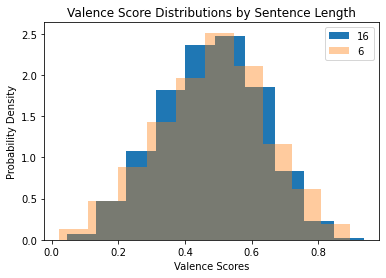

Post Length: 16 Mean Valence: 0.477760688585808 +- 0.14812715003043808
Post Length: 8 Mean Valence: 0.5077963769600266 +- 0.15707404234632993


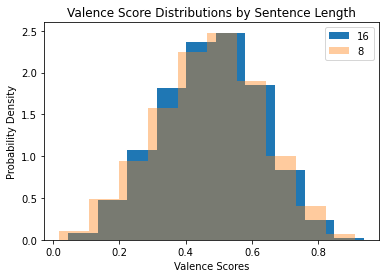

Post Length: 16 Mean Valence: 0.477760688585808 +- 0.14812715003043808
Post Length: 10 Mean Valence: 0.49936970787259694 +- 0.15402977631740902


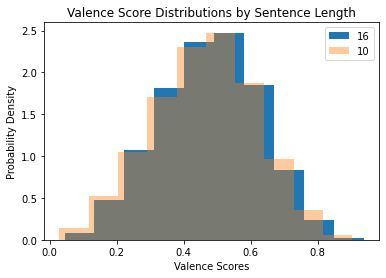

Post Length: 16 Mean Valence: 0.477760688585808 +- 0.14812715003043808
Post Length: 12 Mean Valence: 0.48954691404141637 +- 0.1507032884216419


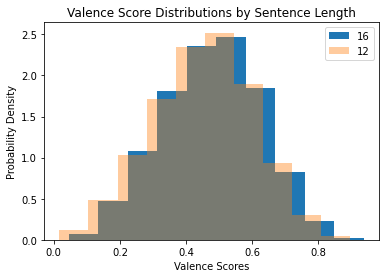

Post Length: 16 Mean Valence: 0.477760688585808 +- 0.14812715003043808
Post Length: 14 Mean Valence: 0.48286898569400205 +- 0.14787030897543157


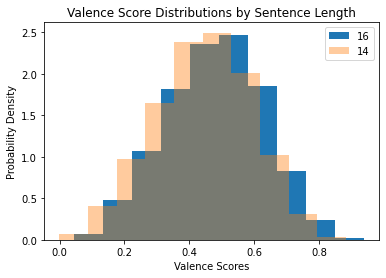

<Figure size 432x288 with 0 Axes>

In [9]:
for small in [6, 8, 10, 12, 14]:
    for key in [16, small]:
        print(f"Post Length: {key} Mean Valence: {len_to_valence[key].mean()} +- {len_to_valence[key].std()}")
        plt.hist(len_to_valence[key] if key == 16 else len_to_valence[key] - 0.04, density=True, alpha=1 if key == 16 else 0.4, label=f"{key}")
    plt.title("Valence Score Distributions by Sentence Length")
    plt.xlabel("Valence Scores")
    plt.ylabel("Probability Density")
    plt.legend()
    plt.show()
    plt.clf()